<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Work-on-the-half-line-term" data-toc-modified-id="Work-on-the-half-line-term-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Work on the half-line term</a></span></li><li><span><a href="#Numerical-scheme-for-the-whole-line-problem" data-toc-modified-id="Numerical-scheme-for-the-whole-line-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical scheme for the whole-line problem</a></span><ul class="toc-item"><li><span><a href="#&quot;Kinky-initial-conditions&quot;" data-toc-modified-id="&quot;Kinky-initial-conditions&quot;-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>"Kinky initial conditions"</a></span></li><li><span><a href="#Gaussian-type-initial-conditions" data-toc-modified-id="Gaussian-type-initial-conditions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gaussian-type initial conditions</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import mpmath

np.set_printoptions(threshold=np.inf) # to look at big matrices

In [266]:
Writer = animation.writers['ffmpeg'] # for animation
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)

### Work on the half-line term

Let $\eta(x,t) = \sin(t) sech(x).$ Then, 
$$
\eta \int^x_0 \eta_t(x',t) ~ dx' = \sin(2t) ~\mathrm{sech}(x) \arctan(\tanh \left(\frac{x}{2} \right) ),
$$
so that 
$$
\partial_t\left( \sin(2t) ~\mathrm{ sech}(x) \arctan(\tanh \left(\frac{x}{2} \right) ) \right) = 2\cos(2t) sech(x) \arctan(\tanh \left(\frac{x}{2} \right) ).
$$
First, we compute $\mathcal{F}^k_c\{2\cos(2t)~\mathrm{ sech}(x) \arctan(\tanh \left(\frac{x}{2} \right) \}$ at various times $t\in[0, 2\pi].$

In [9]:
from scipy.fftpack import dst, idst, dct, idct

In [88]:
def testQ(xx,tt):
    yy = np.copy(xx)
    for k in range(0,len(xx)):
        yy[k] = np.cos(2*tt)*float(mpmath.sech(xx[k]))*np.arctan(np.tanh(xx[k]/2))
        
    return yy

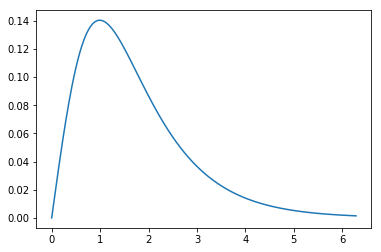

In [224]:
N = 300;
x = np.linspace(0,2*np.pi,N);
t = np.pi/6
y = testQ(x,t)
plt.plot(x, y)

Take the discrete Cosine transform:

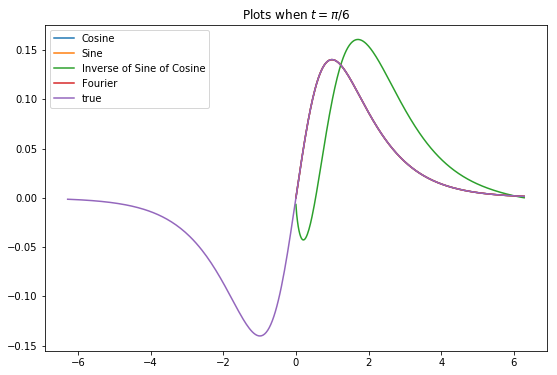

In [226]:
yDCT = dct(y, type=2, norm='ortho')
yIDCT = idct(yDCT, type=2, norm='ortho')
yDST = dst(y, type=2, norm='ortho')
yIDST = idst(yDST, type=2, norm='ortho')
yNEW = idst(yDCT, type=2, norm = 'ortho')
yFFT = np.fft.fft(y)
yIFFT = np.fft.ifft(yFFT)
plt.figure(figsize=(9,6))
plt.plot(x, yIDCT)
plt.plot(x, yIDST)
plt.plot(x, yNEW)
plt.plot(x, yIFFT)
plt.plot(newx, newy)
plt.title("Plots when $t = \pi/6$")
plt.legend(['Cosine', 'Sine', 'Inverse of Sine of Cosine','Fourier','true'])

In [225]:
newx =np.linspace(-2*np.pi,2*np.pi,N);
newy = testQ(newx, t)

Take a simpler function $\eta = \cos(x)$

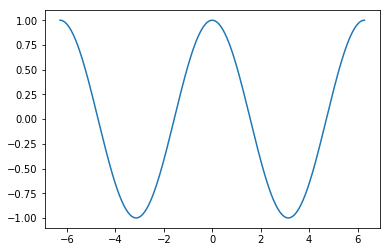

In [228]:
N = 300;
x = np.linspace(-2*np.pi,2*np.pi,N);
y = np.cos(x)
plt.plot(x, y)

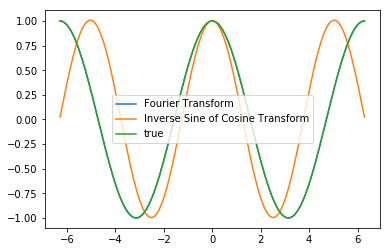

In [229]:
yDCT = dct(y, type=2, norm='ortho')
yIDCT = idst(yDCT, type=2, norm='ortho')
yFFT = np.fft.fft(y)
yIFFT = np.fft.ifft(yFFT)
plt.plot(x, yIFFT)
plt.plot(x, yIDCT)
plt.plot(x, y)
plt.legend(['Fourier Transform','Inverse Sine of Cosine Transform','true'])

### Numerical scheme for the whole-line problem

Recall the equation for the surface on the whole line:
$$
\eta_{tt} - \eta_{xx} = \mu^2 \left( \frac{1}{3}\eta_{xxxx} +\frac{\partial}{\partial x}\left[\frac{\eta^2}{2} + \left(\int^x_{-\infty} \eta_t ~dx' \right)^2\right]\right).
$$ 

In [116]:
def euler(x,f,t0,u0,eta_0,tf,numSteps, mu): # u0 is g_2, eta_0 = g_1, f is the f_1 term in the scheme
    u = np.zeros((numSteps, len(u0)))
    eta = np.zeros((numSteps, len(eta_0)))
    t = np.zeros(numSteps)
      
    t[0], u[0,:], eta[0,:] = t0, u0, eta_0
    dt = (tf-t0)/numSteps
    
    for j in range(0,numSteps-1):
        u[j+1,:] = u[j,:] + dt*f(t[j],u[j,:], eta[j,:], mu, x) # u, eta evaluated at time j
        eta[j+1,:] = eta[j,:] + dt*u[j,:]
        t[j+1] = t[j] + dt
    return t, u, eta

In [161]:
def f1(t_j, u_j, eta_j, mu, x):
    N = len(x)-1
    dx = x[1]-x[0]
    
    A = createA(dx,mu,N)
    B = createB(dx, u_j, eta_j, N)
    F1 = A@eta_j + (mu**2)*B
    return F1

In [141]:
def createA(dx, mu, N):
    x1 = -dx**2 + 4*mu**2
    x2 = 16*(dx**2 - mu**2)
    x3 = -30*dx**2 + 24*mu**2
    x4 = x2 # we changed -x2 to x2
    x5 = x1
    
    D1 = np.diag(x1*np.ones(N-1),-2)
    D2 = np.diag(x2*np.ones(N),-1)
    D3 = np.diag(x3*np.ones(N+1),0)
    D4 = np.diag(x4*np.ones(N),1)
    D5 = np.diag(x5*np.ones(N-1),2)
    
    D = D1 + D2 + D3 + D4 + D5
    
    D[0,0] = 35*dx**2 + 4*mu**2
    D[0,1] = -(104*dx**2 + 16*mu**2)
    D[0,2] = 114*dx**2 + 24*mu**2
    D[0,3] = -(56*dx**2 + 16*mu**2)
    D[0,4] = 11*dx**2 + 4*mu**2
    
    D[1,0] = D[0,4]
    D[1,1] = -(20*dx**2 + 16*mu**2)
    D[1,2] = 6*dx**2 + 24*mu**2
    D[1,3] = (4*dx**2 - 16*mu**2)
    D[1,4] = x1
    
    D[N-1, N-4] = D[1,4]
    D[N-1, N-3] = D[1,3]
    D[N-1, N-2] = D[1,2]
    D[N-1, N-1] = D[1,1]
    D[N-1, N] = D[0,4]
    
    D[N,N] = D[0,0]
    D[N,N-1] = D[0,1]
    D[N,N-2] = D[0,2]
    D[N,N-3] = D[0,3]
    D[N,N-4] = D[0,4]
    
    A = 1/(12*dx**2)*D
    
    return A

In [110]:
def createB(dx, u_j, eta_j, N):
    integrals = np.zeros(len(eta_j))
    B = np.zeros(len(eta_j))
    for i in range(1, N+1):
        int_k = 0
        for k in range(0, i):
            int_k = int_k + u_j[k] + u_j[k+1]
        int_k = dx*int_k/2
        integrals[i] = int_k
    
    for k in range(2, N-1):
        uj_x = (u_j[k-2] - 8*u_j[k-1] + 8*u_j[k+1] - u_j[k+2])/(12*dx)
        etaj_x = (eta_j[k-2] - 8*eta_j[k-1] + 8*eta_j[k+1] - eta_j[k+2])/(12*dx)
        etaj_xx = (-eta_j[k-2] + 16*eta_j[k-1] - 30*eta_j[k] + 16*eta_j[k+1] - eta_j[k+2])/(12*dx**2)
        B[k] = 2*uj_x*integrals[k-1] + 2*u_j[k]**2 + (etaj_x)**2 + eta_j[k]*etaj_xx
        
    eta_x0 = (-25*eta_j[0] + 48*eta_j[1] - 36*eta_j[2] + 16*eta_j[3] - 3*eta_j[4])/(12*dx)
    eta_xx0 = (35*eta_j[0] - 104*eta_j[1] + 114*eta_j[2] - 56*eta_j[3] + 11*eta_j[4])/(12*dx**2)
    B[0] = 2*u_j[0]**2 + (eta_x0)**2 + eta_j[0]*eta_xx0
    
    eta_x1 = (-3*eta_j[0] - 10*eta_j[1] + 18*eta_j[2] - 6*eta_j[3] + eta_j[4])/(12*dx)
    eta_xx1 = (11*eta_j[0] - 20*eta_j[1] + 6*eta_j[2] + 4*eta_j[3] - eta_j[4])/(12*dx**2)
    u_x1 = (-3*u_j[0] - 10*u_j[1] + 18*u_j[2] - 6*u_j[3] + u_j[4])/(12*dx)
    B[1] = 2*u_x1*integrals[1] + 2*u_j[1]**2 + (eta_x1)**2 + eta_j[0]*eta_xx1
    
    eta_xn1 = (-eta_j[N-4] + 6*eta_j[N-3] - 18*eta_j[N-2] + 10*eta_j[N-1] + 3*eta_j[N])/(12*dx)
    eta_xxn1 = (-eta_j[N-4] + 4*eta_j[N-3] + 6*eta_j[N-2] -20*eta_j[N-1] - 11*eta_j[N])/(12*dx**2)
    u_xn1 = (-u_j[N-4] + 6*u_j[N-3] - 18*u_j[N-2] + 10*u_j[N-1] + 3*u_j[N])/(12*dx)
    B[N-1] = 2*u_xn1*integrals[N-1] + 2*u_j[N-1]**2 + (eta_xn1)**2 + eta_j[N-1]*eta_xxn1
    
    eta_xn = (3*eta_j[N-4] - 16*eta_j[N-3] + 36*eta_j[N-2] - 48*eta_j[N-1] + 25*eta_j[N])/(12*dx)
    eta_xxn = (11*eta_j[N-4] - 56*eta_j[N-3] + 114*eta_j[N-2] - 104*eta_j[N-1] + 35*eta_j[N])/(12*dx**2)
    u_xn = (3*u_j[N-4] - 16*u_j[N-3] + 36*u_j[N-2] - 48*u_j[N-1] + 25*u_j[N])/(12*dx)
    B[N] = 2*u_xn*integrals[N] + 2*u_j[N]**2 + (eta_xn)**2 + eta_j[N]*eta_xxn
    
    return B

#### "Kinky initial conditions"

Let the interval be $[-5,5]$. The initial conditions are: 
$$
\eta_t(x,0) = \mathrm{sech}(5x)^2 + \mathrm{sech}(5x-10)^2, \qquad \eta(x,0) = \mathrm{sech}(10x)^2 - \mathrm{sech}(10x-20)^2.
$$

In [244]:
def G0(xx):
    yy = np.copy(xx)
    for k in range(0,len(xx)):
        yy[k] = float(mpmath.sech(5*xx[k]))**2 + float(mpmath.sech(5*xx[k]-10))**2
    return yy

def G1(xx):
    yy = np.copy(xx)
    for k in range(0,len(xx)):
        yy[k] = float(mpmath.sech(10*xx[k]))**2 - float(mpmath.sech(10*xx[k]-20))**2
    return yy

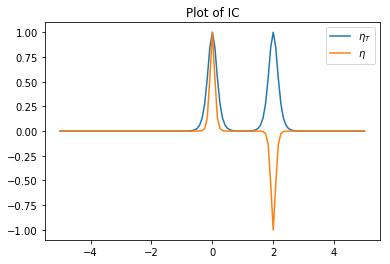

In [245]:
N = 120
xx = np.linspace(-5,5, N+1)
g0 = G0(xx)
g1 = G1(xx)
mu = 0.01
t0 = 0
tf = 10
numSteps = 40

plt.plot(xx, g0)
plt.plot(xx, g1)
plt.title('Plot of IC')
plt.legend([r'$\eta_T$', r'$\eta$'])

Text(0.5,1,'Numerical Solution for $t \\in [0,10]$ for first 10 (out of 40) time steps')

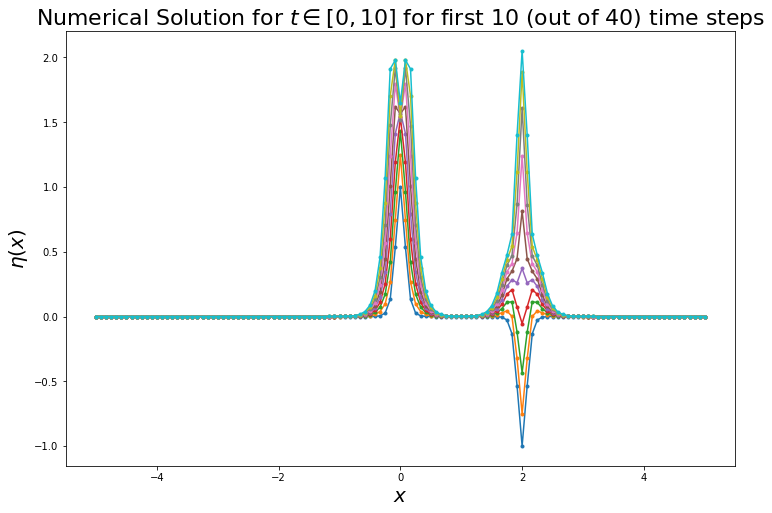

In [246]:
tt, U, Eta = euler(xx, f1, t0, g0, g1, tf, numSteps, mu)
plt.figure(figsize=(12,8))
for k in range(0, 10):
    plt.plot(xx, Eta[k],'.-')
    
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\eta(x)$',fontsize=20)
plt.title('Numerical Solution for $t \in [0,10]$ for first 10 (out of 40) time steps',fontsize=22)

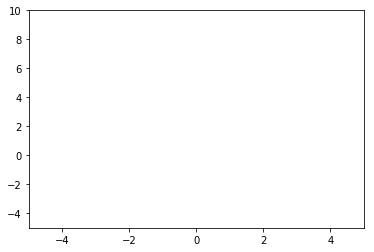

In [263]:
fig = plt.figure()
ax = plt.axes(xlim=(-5,5), ylim= (-5,10))
line, = ax.plot([], [], lw=2)
    
def animate(t):
    X = xx
    Y = Eta[t,:]
    line.set_data(X, Y)
    return line,
def init():
    line.set_data([],[])
    return line,
anim = FuncAnimation(fig, animate, init_func = init, frames = numSteps, interval = 1)
anim.save('basic_animation_KinkyIC.mp4', writer = writer)

#### Gaussian-type initial conditions
Let the interval be $[-5,5]$. The initial conditions are: 
$$
\eta_t(x,0) = \mathrm{sech}(x)^2, \qquad \eta(x,0) = \exp(-x^2).
$$

In [271]:
def G0(xx):
    yy = np.copy(xx)
    for k in range(0,len(xx)):
        yy[k] = float(mpmath.sech(xx[k]))**2 
    return yy

def G1(xx):
    yy = np.copy(xx)
    for k in range(0,len(xx)):
        yy[k] = np.exp(-xx[k]**2)
    return yy

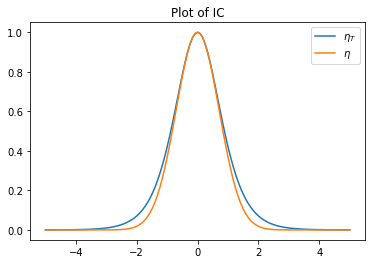

In [272]:
N = 120
xx = np.linspace(-5,5, N+1)
g0 = G0(xx)
g1 = G1(xx)
mu = 0.01
t0 = 0
tf = 10
numSteps = 40

plt.plot(xx, g0)
plt.plot(xx, g1)
plt.title('Plot of IC')
plt.legend([r'$\eta_T$', r'$\eta$'])

Text(0.5,1,'Numerical Solution for $t \\in [0,10]$ for first 10 (out of 40) time steps')

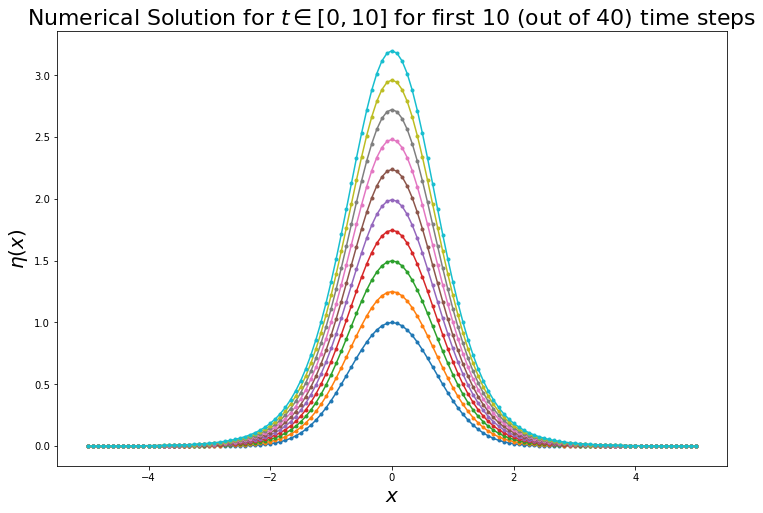

In [273]:
tt, U, Eta = euler(xx, f1, t0, g0, g1, tf, numSteps, mu)
plt.figure(figsize=(12,8))
for k in range(0, 10):
    plt.plot(xx, Eta[k],'.-')
    
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$\eta(x)$',fontsize=20)
plt.title('Numerical Solution for $t \in [0,10]$ for first 10 (out of 40) time steps',fontsize=22)

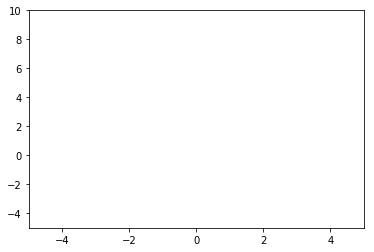

In [274]:
fig = plt.figure()
ax = plt.axes(xlim=(-5,5), ylim= (-5,10))
line, = ax.plot([], [], lw=2)
    
def animate(t):
    X = xx
    Y = Eta[t,:]
    line.set_data(X, Y)
    return line,
def init():
    line.set_data([],[])
    return line,
anim = FuncAnimation(fig, animate, init_func = init, frames = numSteps, interval = 1)
anim.save('basic_animation_GaussianIC.mp4', writer = writer)